In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
ae_loss = 'emd'
class_name = raw_input('Give me the class type: ').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

Give me the class type: chair


In [5]:
# Load AE
syn_id = shape_net_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '10'     # 32 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [6]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [7]:
train_data = PointCloudDataSet(pclouds)

In [8]:
ae_conf.saver_step = None
ae_conf.training_epochs = 1

In [9]:
def train_me(self, train_data, configuration, log_file=None):
        c = configuration
        stats = []

        if c.saver_step is not None:
            create_dir(c.train_dir)

        for _ in xrange(c.training_epochs):
            loss, duration = self._single_epoch_train(train_data, c)
            epoch = int(self.sess.run(self.epoch.assign_add(tf.constant(1.0))))
            stats.append((epoch, loss, duration))

            if epoch % c.loss_display_step == 0:
                print("Epoch:", '%04d' % (epoch), 'training time (minutes)=', "{:.4f}".format(duration / 60.0), "loss=", "{:.9f}".format(loss))
                if log_file is not None:
                    log_file.write('%04d\t%.9f\t%.4f\n' % (epoch, loss, duration / 60.0))

            # Save the models checkpoint periodically.
            if c.saver_step is not None and (epoch % c.saver_step == 0 or epoch - 1 == 0):
                checkpoint_path = osp.join(c.train_dir, model_saver_id)
                self.saver.save(self.sess, checkpoint_path, global_step=self.epoch)

#             if c.summary_step is not None and (epoch % c.summary_step == 0 or epoch - 1 == 0):
#                 loss_pl = tf.placeholder(tf.float64, [])
#                 tf.summary.scalar("Total Loss", loss_pl.assign(loss))
#                 summary = self.sess.run(self.merged_summaries)
#                 self.train_writer.add_summary(summary, epoch)



In [10]:
ae_conf.batch_size = 200
train_me(ae, train_data, ae_conf)

ae_conf.batch_size = 40
train_me(ae, train_data, ae_conf)

('Epoch:', '1001', 'training time (minutes)=', '0.3644', 'loss=', '59.611169757')
('Epoch:', '1002', 'training time (minutes)=', '0.4342', 'loss=', '56.655828307')


In [71]:
shape_id = 25
g, r = ae.sess.run([tf.gradients(ae.z, ae.x), ae.x_reconstr], feed_dict={ae.x: pclouds[shape_id].reshape(1,2048,3)})
g = g[0][0]
r = r[0]

(-0.5, 0.5)

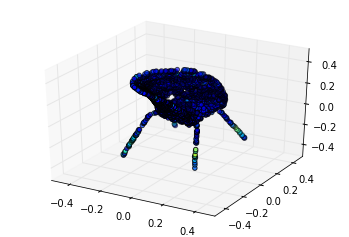

In [72]:
c = np.linalg.norm(g, axis=1)
c /= np.max(c)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pclouds[shape_id,:,0], pclouds[shape_id,:,1], pclouds[shape_id,:,2], c=c)
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)

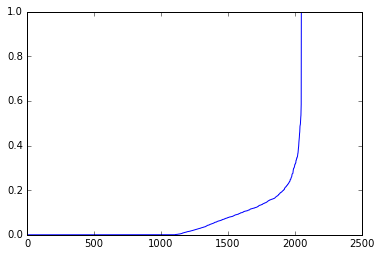

In [73]:
plt.plot(sorted(c))

array([ 0.93438619,  1.06518829,  1.04011083, ...,  1.94551861,
        1.18267262,  1.33339715], dtype=float32)

(2048, 3)